In [15]:
%%time
import sys
!{sys.executable} -m pip install xgboost
#!{sys.executable} -m pip install -r requirements.txt


You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
CPU times: user 42.6 ms, sys: 12.1 ms, total: 54.6 ms
Wall time: 2.08 s


In [16]:
%%time
import numpy as np
from xgboost import XGBClassifier
from matplotlib import pyplot
from matplotlib.pyplot import figure
from numpy import loadtxt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, auc, roc_auc_score, balanced_accuracy_score

CPU times: user 72 µs, sys: 1e+03 ns, total: 73 µs
Wall time: 76.3 µs


In [17]:
%%time
import pandas as pd
df = pd.read_csv('numerical_only_all.csv')
columns = df.columns()
print('Length', len(df))

Length 6362619
CPU times: user 3.64 s, sys: 536 ms, total: 4.18 s
Wall time: 49.6 s


In [18]:
dataset = df.to_numpy()

X = dataset[:,1:]
y = dataset[:,0]

In [19]:
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

In [20]:
%%time
import datetime
print(str(datetime.datetime.now())[:-7])
model = XGBClassifier()
model.fit(X, y)

2020-11-30 20:01:30
[20:01:35] WARNING: ../src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
CPU times: user 42min 57s, sys: 16 s, total: 43min 13s
Wall time: 11min 2s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='approx', validate_parameters=1, verbosity=None)

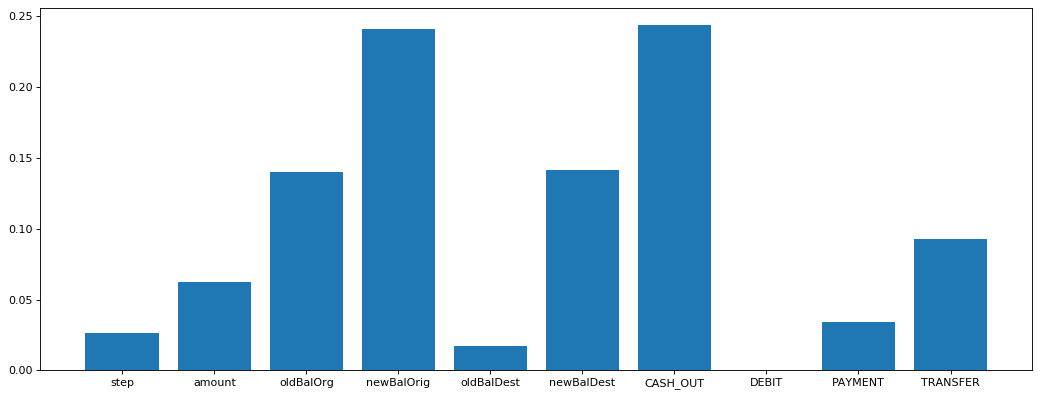

CPU times: user 659 ms, sys: 15.9 ms, total: 675 ms
Wall time: 373 ms


In [21]:
%%time

fields ='step	amount	oldbalanceOrg	newbalanceOrig	oldbalanceDest	newbalanceDest	CASH_OUT	DEBIT	PAYMENT	TRANSFER'
fields_arr = fields.split('\t')
columns=columns[1:]

assert columns==fields, f'{columns} != {fields}'

fields_arr = [s.replace('balance', 'Bal') for s in fields_arr]
 
figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_, tick_label=fields_arr)
        
pyplot.show()

In [ ]:
model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
print("accuracy_score: %.2f%%" % (accuracy_score(y_test, predictions) * 100.0))
print("f1_score: %.2f%%" % (f1_score(y_test, predictions) * 100.0))
print("precision_score: %.2f%%" % ( recision_score(y_test, predictions) * 100.0))
print("recall_score: %.2f%%" % (recall_score(y_test, predictions) * 100.0))
print("roc_auc_score: %.2f%%" % (roc_auc_score(y_test, predictions) * 100.0))
print("balanced_accuracy_score: %.2f%%" % (balanced_accuracy_score(y_test, predictions) * 100.0))


[20:12:36] WARNING: ../src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
